# Importing libraries

This code works for only when full frontal face is visible. One needs sophisticated deep learning based sophisticated facial landmarks to detect acne in different face orientation.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

# Utility Functions

In [15]:
# utility function to detect face using dlib frontal face detector and 81_point face landmark predictor
def detect_face(img):
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('models/shape_predictor_81_face_landmarks.dat')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rect = detector(gray, 1)[0]
    landmarks = predictor(gray, rect)
    
    face_hull   = cv2.convexHull(np.array([[landmarks.part(n).x,landmarks.part(n).y] for n in range(0, 81)]))
    
    lebrow_hull = cv2.convexHull(np.array([[landmarks.part(n).x,landmarks.part(n).y] for n in range(17, 22)]))
    rebrow_hull = cv2.convexHull(np.array([[landmarks.part(n).x,landmarks.part(n).y] for n in range(22, 27)]))
    
    leye_hull   = cv2.convexHull(np.array([[landmarks.part(n).x,landmarks.part(n).y] for n in range(36, 42)]))
    reye_hull   = cv2.convexHull(np.array([[landmarks.part(n).x,landmarks.part(n).y] for n in range(42, 48)]))
    nose_hull   = cv2.convexHull(np.array([[landmarks.part(n).x,landmarks.part(n).y] for n in range(27, 36)]))
    lip_hull    = cv2.convexHull(np.array([[landmarks.part(n).x,landmarks.part(n).y] for n in range(48, 68)]))
    
    orig_img    = img.copy()
    lebrow_mask = np.ones((img.shape[0], img.shape[1]))
    rebrow_mask = np.ones((img.shape[0], img.shape[1]))
    lip_mask  = np.ones((img.shape[0], img.shape[1]))
    reye_mask = np.ones((img.shape[0], img.shape[1]))
    leye_mask = np.ones((img.shape[0], img.shape[1]))
    nose_mask = np.ones((img.shape[0], img.shape[1]))
    face_mask = np.zeros((img.shape[0], img.shape[1]))
    
     
    face_mask = cv2.fillConvexPoly(face_mask, face_hull, 1).astype(np.uint8)
    nose_mask = cv2.fillConvexPoly(nose_mask, nose_hull, 0).astype(np.uint8)
    reye_mask = cv2.fillConvexPoly(reye_mask, reye_hull, 0).astype(np.uint8)
    leye_mask = cv2.fillConvexPoly(leye_mask, leye_hull, 0).astype(np.uint8)
    lip_mask = cv2.fillConvexPoly(lip_mask, lip_hull, 0).astype(np.uint8)
    lebrow_mask = cv2.fillConvexPoly(lebrow_mask, lebrow_hull, 0).astype(np.uint8)
    rebrow_mask = cv2.fillConvexPoly(rebrow_mask, rebrow_hull, 0).astype(np.uint8)
    
    img = cv2.bitwise_and(img,img,mask = face_mask)
    
    img = cv2.bitwise_and(img,img,mask = nose_mask)
    img = cv2.bitwise_and(img,img,mask = reye_mask)
    img = cv2.bitwise_and(img,img,mask = leye_mask)
    img = cv2.bitwise_and(img,img,mask = lip_mask)
    img = cv2.bitwise_and(img,img,mask = lebrow_mask)
    img = cv2.bitwise_and(img,img,mask = rebrow_mask)
    
    return img,orig_img

# Algorithm to detect acne severity
def detect_acne(face,orig_img):
    orig_img = orig_img.copy()
    gray = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
    h1,w1  = gray.shape
    face_area = np.count_nonzero(gray)/(h1*w1)

    th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,5)
    th3 = cv2.dilate(th3,np.ones((1,1)),iterations = 2)
    contours, hierarchy = cv2.findContours(th3.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    acne_area = 0
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area >= 20 and area <= 70:
            (x,y,w,h)    = cv2.boundingRect(cnt)
            orig_img_roi = orig_img[y:y+h,x:x+w,:]
            cv2.rectangle(orig_img, (x,y), (x+w,y+h), (0, 0, 255), 2)
            acne_area   +=w*h
    acne_area = acne_area/(h1*w1)       
    
    return orig_img,acne_area/face_area

# show and process each image
def process_and_show_img(img_path):
    img               = cv2.imread(img_path)
    face,orig_img     = detect_face(img)
    acne_face,acne_area    = detect_acne(face,orig_img)
    acne_face         = cv2.cvtColor(acne_face,cv2.COLOR_BGR2RGB)
    orig_img          = cv2.cvtColor(orig_img,cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(16,10))
    ax1 =plt.subplot(121)
    ax1.set_title('Original Image')
    ax1.imshow(orig_img)
    plt.axis('off')
    ax2 =plt.subplot(122)
    ax2.set_title('Acne Severity Score={}'.format(np.uint8(acne_area*100)))
    ax2.imshow(acne_face)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()
    

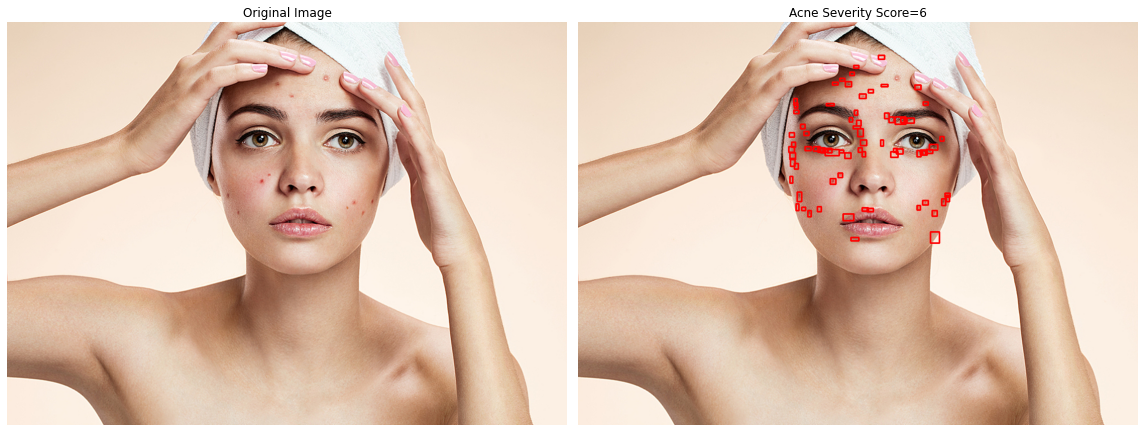

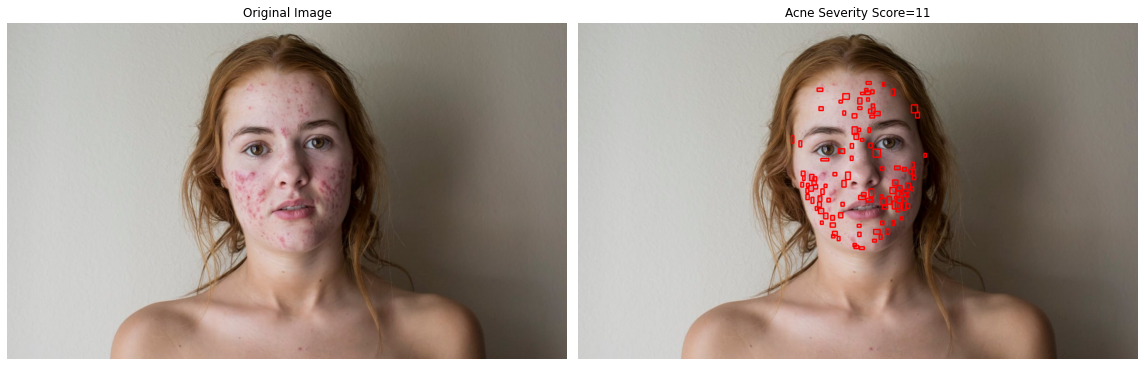

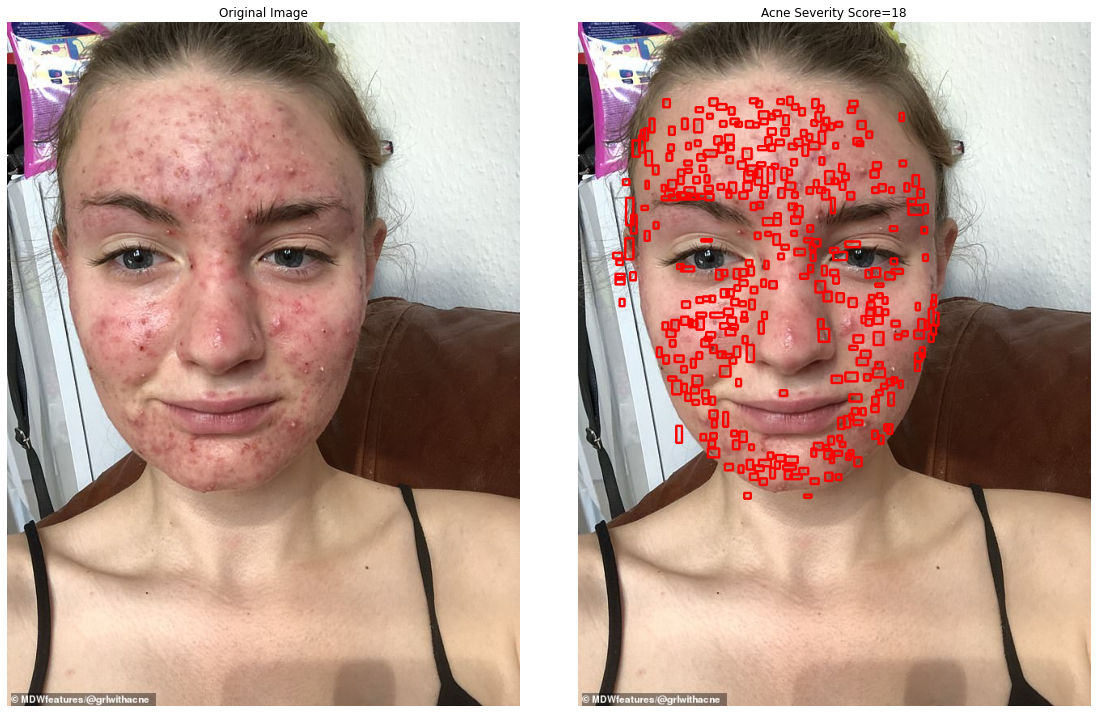

In [16]:
process_and_show_img('./data/acne_zero.jpg')
process_and_show_img('./data/acne_mild.jpg')
process_and_show_img('./data/acne_severe.jpg')